In [1]:
!pip install -q ultralytics==8.3.202 opencv-python matplotlib PyYAML

from ultralytics import YOLO
import zipfile, os, shutil, json, glob
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
WEIGHTS = "/content/best.pt"  # best.pt from your training run
ZIP_PATH = "/content/drive/MyDrive/hackwithhyderabad/Hackathon2_test1.zip"  # your test zip
INNER_ROOT = "test1"
OUT_DIR = Path("/content/runs/test_eval")
IMGSZ = 640
CONF = 0.25
IOU = 0.7

In [3]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
UNZIP_DIR = OUT_DIR / "unzipped"
if UNZIP_DIR.exists():
    shutil.rmtree(UNZIP_DIR)
with zipfile.ZipFile(ZIP_PATH, "r") as zf:
    zf.extractall(UNZIP_DIR)

ROOT = UNZIP_DIR / INNER_ROOT
IMG_DIR = ROOT / "images"
LBL_DIR = ROOT / "labels"
assert IMG_DIR.exists() and LBL_DIR.exists(), f"Expected {ROOT}/images and {ROOT}/labels to exist"

In [4]:
names = ['OxygenTank','NitrogenTank','FirstAidBox','FireAlarm','SafetySwitchPanel','EmergencyPhone','FireExtinguisher']
DATA_YAML = OUT_DIR / "data_test.yaml"
DATA_YAML.write_text(f"""
path: {ROOT}
train: {IMG_DIR}    # unused in this test
val: {IMG_DIR}      # we evaluate on these images using labels under {LBL_DIR}
test: {IMG_DIR}
names: {names}
""")

452

In [5]:
model = YOLO(WEIGHTS)

In [6]:
metrics = model.val(
    data=str(DATA_YAML),
    imgsz=IMGSZ,
    conf=CONF,
    iou=IOU,
    split="val",
    plots=True,            # PR curves, confusion matrix, F1 curve, etc.
    save_hybrid=True,      # saves label+pred pairs for analysis
    project=str(OUT_DIR),
    name="metrics",
)
print({
    "map50": float(metrics.box.map50),
    "map50_95": float(metrics.box.map),
    "precision": float(metrics.box.mp),
    "recall": float(metrics.box.mr),
})

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 379.1±581.3 MB/s, size: 3043.6 KB)
val: Scanning /content/runs/test_eval/unzipped/test1/labels... 1408 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1408/1408 71.5it/s 19.7s
val: New cache created: /content/runs/test_eval/unzipped/test1/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 88/88 0.1it/s 11:43
                   all       1408       5862      0.839      0.558      0.732      0.636
            OxygenTank        734       1552      0.894      0.711      0.835      0.769
          NitrogenTank        703       1616      0.849      0.625      0.773      0.732
           FirstAidBox        554        815      0.867  

In [7]:
pred_results = model.predict(
    source=str(IMG_DIR),
    imgsz=IMGSZ,
    conf=CONF,
    iou=IOU,
    save=True,             # annotated images
    save_txt=True,         # YOLO-format predictions
    project=str(OUT_DIR),
    name="predictions",
    verbose=True
)
pred_dir = Path(pred_results[0].save_dir) if pred_results else OUT_DIR / "predictions"
print("Predictions saved at:", pred_dir)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1408 /content/runs/test_eval/unzipped/test1/images/000000001_light_unclutter.png: 384x640 1 NitrogenTank, 1 FirstAidBox, 358.7ms
image 2/1408 /content/runs/test_eval/unzipped/test1/images/000000001_vdark_clutter.png: 384x640 2 OxygenTanks, 2 NitrogenTanks, 2 FirstAidBoxs, 1 FireExtinguisher, 330.5ms
image 3/1408 /content/runs/test_eval/unzipped/test1/images/000000002_dark_clutter.png: 384x640 1 OxygenTank, 342.3ms
image 4/1408 /content/runs/tes

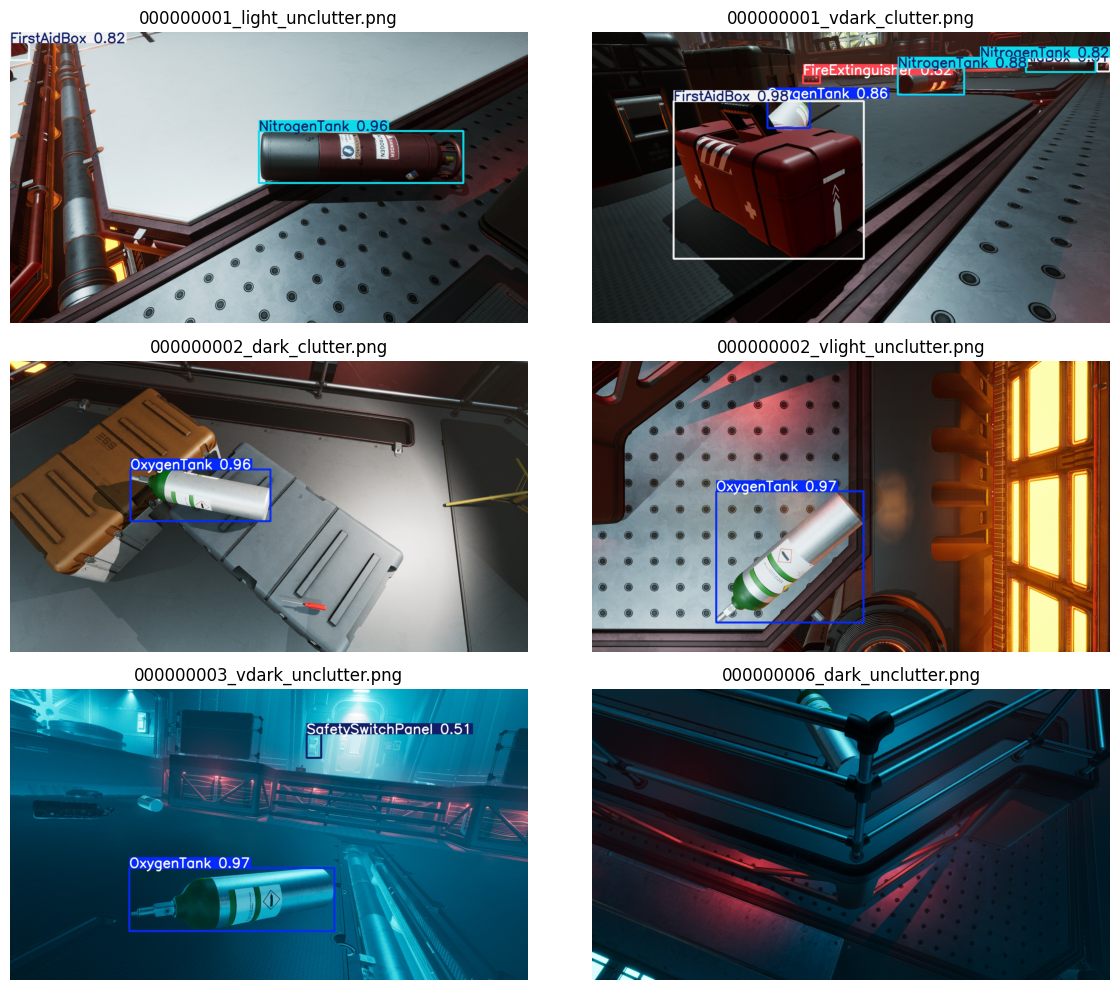

In [8]:
sample_imgs = sorted(glob.glob(str(IMG_DIR / "*.png")))[:6] or sorted(glob.glob(str(IMG_DIR / "*.jpg")))[:6]
plt.figure(figsize=(12, 10))
for i, p in enumerate(sample_imgs, 1):
    fname = Path(p).name
    ann_path = pred_dir / fname  # Ultralytics uses original filename for save=True outputs
    if not ann_path.exists():
        # Fallback: sometimes images saved as .jpg even if source was .png
        alt = pred_dir / (Path(fname).stem + ".jpg")
        if alt.exists():
            ann_path = alt
    if ann_path.exists():
        img = plt.imread(ann_path)
        plt.subplot(3, 2, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(fname)
plt.tight_layout()
plt.show()

In [9]:
(Path(OUT_DIR) / "metrics.json").write_text(json.dumps({
    "map50": float(metrics.box.map50),
    "map50_95": float(metrics.box.map),
    "precision": float(metrics.box.mp),
    "recall": float(metrics.box.mr),
}, indent=2))

134

In [10]:
ZIP_OUT = str(OUT_DIR) + ".zip"
if os.path.exists(ZIP_OUT):
    os.remove(ZIP_OUT)
shutil.make_archive(base_name=str(OUT_DIR), format="zip", root_dir=str(OUT_DIR))
print("Zipped outputs at:", ZIP_OUT)
files.download(ZIP_OUT)

Zipped outputs at: /content/runs/test_eval.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>